In [1]:
!pip install mplcyberpunk

In [2]:
import os
import kagglehub
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
from keras import layers, Model, optimizers, losses, metrics, applications

plt.style.use('cyberpunk')

2025-08-09 04:08:12.394686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754712492.554776      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754712492.604061      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
images_dirs = {
    'test' : '/kaggle/input/flowers16/flowersData/test',
    'train' : '/kaggle/input/flowers16/flowersData/train',
    'valid' : '/kaggle/input/flowers16/flowersData/valid',
}

In [4]:
raw_labels = os.listdir(images_dirs['train'])
class_labels = {label : idx for idx, label in enumerate(raw_labels)}
inv_class_labels = inv_map = {v: k for k, v in class_labels.items()}
class_labels

{'plumeria': 0,
 'orchid': 1,
 'saffron flower': 2,
 'daffodil': 3,
 'bougainvillea': 4,
 'chinese hibiscus': 5,
 'lavender': 6,
 'marigold': 7,
 'dandelion': 8,
 'lily': 9,
 'daisy': 10,
 'sunflower': 11,
 'tulip': 12,
 'lotus': 13,
 'rose': 14,
 'iris': 15}

In [5]:
def check_image(file):
    image = tf.io.read_file(file)
    image = tf.image.decode_image(image, channels=3)

def get_image_paths_and_labels(image_dir, label_dict):
    images = []
    labels = []
    
    for label in label_dict.keys():
        current_label = os.path.join(image_dir, label)
        for img in os.listdir(current_label):
            try:
                full_img = os.path.join(current_label, img)
                check_image(full_img)
                images.append(full_img)
                labels.append(label_dict[label])
            except:
                print(f'Invalid Image:{full_img}')
                continue

    return images, labels

train_image_paths, train_labels = get_image_paths_and_labels(images_dirs['train'], class_labels)
val_image_paths, val_labels = get_image_paths_and_labels(images_dirs['valid'], class_labels)
test_image_paths, test_labels = get_image_paths_and_labels(images_dirs['test'], class_labels)

I0000 00:00:1754712507.114110      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754712507.114945      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Invalid SOS parameters for sequential JPEG


Invalid Image:/kaggle/input/flowers16/flowersData/train/daffodil/000064.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/daffodil/000020.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/bougainvillea/000009.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/chinese hibiscus/000018.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/marigold/000046.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/marigold/000007.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/marigold/000048.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/lily/000033.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/lily/000059.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/train/sunflower/000039.png
Invalid Image:/kaggle/input/flowers16/flowersData/train/sunflower/000027.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/valid/saffron flower/000011.jpg
Invalid Image:/kaggle/input/flowers16/flowersData/test/rose/000007.jpg


In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

In [7]:
def load_image(image, cls):
    image = tf.io.read_file(image)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, (256, 256))
    return tf.cast(image, tf.float32), tf.cast(cls, tf.float32)

train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
def configure_dataset(ds : tf.data.Dataset):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(64, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = configure_dataset(train_ds)
val_ds = configure_dataset(val_ds)
test_ds = configure_dataset(test_ds)

In [9]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images, label):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images, label

train_ds = train_ds.map(img_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
def freeze_model(model, num_classes):
    inputs = layers.Input((256, 256, 3))
    
    transfer_model = model(include_top=False, input_tensor=inputs, weights="imagenet")
    transfer_model.trainable = False

    x = layers.GlobalAveragePooling2D()(transfer_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    frozen_model = Model(inputs, outputs)
    return frozen_model

resnet101 = applications.ResNet101
efficientnetb7 = applications.EfficientNetB7

frozen_resnet101 = freeze_model(resnet101, 16)
frozen_efficientnetb7 = freeze_model(efficientnetb7, 16)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
frozen_resnet101.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=1e-2),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

frozen_efficientnetb7.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=1e-2),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [12]:
frozen_resnet101_history = frozen_resnet101.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

frozen_efficientnetb7_history = frozen_efficientnetb7.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

Epoch 1/20


Invalid SOS parameters for sequential JPEG
I0000 00:00:1754712605.380324      66 service.cc:148] XLA service 0x7e08e4003e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754712605.381057      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754712605.381096      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754712609.111244      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754712617.853023      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 2.6114 - sparse_categorical_accuracy: 0.4214 - val_loss: 1.6733 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 511ms/step - loss: 1.1860 - sparse_categorical_accuracy: 0.7864 - val_loss: 1.0598 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 522ms/step - loss: 0.9328 - sparse_categorical_accuracy: 0.8236 - val_loss: 1.4984 - val_sparse_categorical_accuracy: 0.7344
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - loss: 0.8530 - sparse_categorical_accuracy: 0.8073 - val_loss: 0.9687 - val_sparse_categorical_accuracy: 0.8438
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 521ms/step - loss: 0.7436 - sparse_categorical_accuracy: 0.8496 - val_loss: 1.0628 - val_sparse_categorical_accuracy: 0.8281
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 557ms/step - loss: 0.7351 - sparse_categorical_accuracy: 0.8518 - val_loss: 1.1679 - val_sparse_categorical_accuracy: 0.8125
Epoch 7/20
1

E0000 00:00:1754712920.378799      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754712920.615106      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-09 04:15:31.043778: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[64,640,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3840,8,8]{3,2,1,0}, f32[640,3840,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-09 04:15:31.069790: E external/

17/17 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - loss: 3.0527 - sparse_categorical_accuracy: 0.3908 - val_loss: 1.1588 - val_sparse_categorical_accuracy: 0.5625
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 696ms/step - loss: 1.6218 - sparse_categorical_accuracy: 0.7235 - val_loss: 1.2151 - val_sparse_categorical_accuracy: 0.5938
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 739ms/step - loss: 1.4543 - sparse_categorical_accuracy: 0.7711 - val_loss: 1.2365 - val_sparse_categorical_accuracy: 0.5781
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 707ms/step - loss: 1.1506 - sparse_categorical_accuracy: 0.8236 - val_loss: 1.0938 - val_sparse_categorical_accuracy: 0.6094
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 692ms/step - loss: 1.3063 - sparse_categorical_accuracy: 0.8028 - val_loss: 0.9652 - val_sparse_categorical_accuracy: 0.7344
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 687ms/step - loss: 1.3708 - sparse_categorical_accuracy: 0.8120 - val_loss: 1.1262 - val_sparse_categorical_accuracy: 0.6562
Epoch 7/20


In [13]:
def plot_keras_metrics(hist, model, sub, metric, colors):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f'Metrics for {sub} {model} Model')
    ax[0].set_title(f'Losses for {sub} {model} Model')
    ax[0].set_ylabel(f'Loss')
    ax[0].plot(hist['loss'], color=colors[0], label='Loss')
    ax[0].plot(hist['val_loss'], color=colors[1], label='Val Loss')
    
    ax[1].set_title(f'{metric.capitalize()} for {sub} {model} Model')
    ax[1].set_ylabel(f'{metric.capitalize()}')
    ax[1].plot(hist[metric], color=colors[2], label=metric.capitalize())
    ax[1].plot(hist['val_'+metric], color=colors[3], label='Val ' + metric)

    for i in range(2):
        axes = ax[i]
        axes.set_xlabel('Epochs')
        axes.legend()
        mplcyberpunk.make_lines_glow(ax=axes)
        mplcyberpunk.add_underglow(ax=axes)

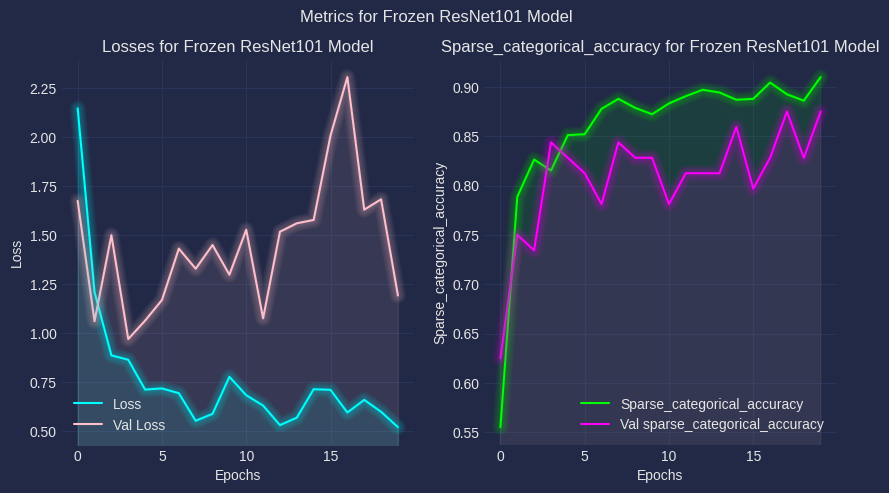

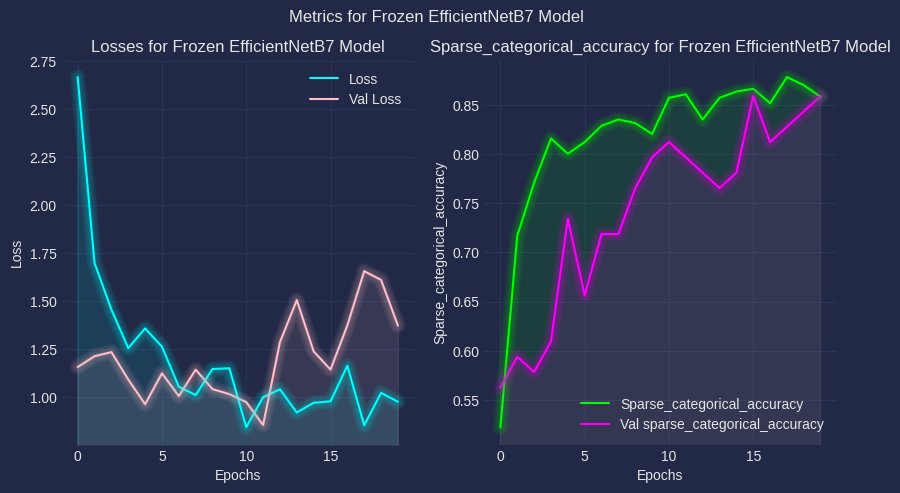

In [14]:
frozen_resent101_hist = frozen_resnet101_history.history
frozen_efficientnetb7_hist = frozen_efficientnetb7_history.history

plot_keras_metrics(
    hist=frozen_resent101_hist,
    model='ResNet101',
    sub='Frozen',
    metric='sparse_categorical_accuracy',
    colors=['cyan', 'pink', 'lime', 'magenta']
)

plot_keras_metrics(
    hist=frozen_efficientnetb7_hist,
    model='EfficientNetB7',
    sub='Frozen',
    metric='sparse_categorical_accuracy',
    colors=['cyan', 'pink', 'lime', 'magenta']
)

In [15]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    return model

unfrozen_resnet101 = unfreeze_model(frozen_resnet101)
unfrozen_efficientnetb7 = unfreeze_model(frozen_efficientnetb7)

In [16]:
unfrozen_resnet101.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

unfrozen_efficientnetb7.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [17]:
unfrozen_resnet101_history = unfrozen_resnet101.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

unfrozen_efficientnetb7_history = unfrozen_efficientnetb7.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - loss: 0.4681 - sparse_categorical_accuracy: 0.9158 - val_loss: 1.9789 - val_sparse_categorical_accuracy: 0.8438
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 569ms/step - loss: 0.5813 - sparse_categorical_accuracy: 0.9067 - val_loss: 2.0493 - val_sparse_categorical_accuracy: 0.7969
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step - loss: 0.5054 - sparse_categorical_accuracy: 0.9195 - val_loss: 2.3204 - val_sparse_categorical_accuracy: 0.8125
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 570ms/step - loss: 0.5310 - sparse_categorical_accuracy: 0.9176 - val_loss: 2.6826 - val_sparse_categorical_accuracy: 0.7656
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 524ms/step - loss: 0.3531 - sparse_categorical_accuracy: 0.9264 - val_loss: 2.4616 - val_sparse_categorical_accuracy: 0.7969
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - loss: 0.4074 - sparse_categorical_accuracy: 0.9306 - val_loss: 1.8888 - val_sparse_categorical_accuracy: 0.8438
E

E0000 00:00:1754713595.396738      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754713595.619136      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


17/17 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - loss: 0.8677 - sparse_categorical_accuracy: 0.8926 - val_loss: 1.2999 - val_sparse_categorical_accuracy: 0.8594
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 740ms/step - loss: 0.8707 - sparse_categorical_accuracy: 0.8845 - val_loss: 1.9207 - val_sparse_categorical_accuracy: 0.8125
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 755ms/step - loss: 0.7561 - sparse_categorical_accuracy: 0.8964 - val_loss: 1.3902 - val_sparse_categorical_accuracy: 0.8594
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 734ms/step - loss: 0.6802 - sparse_categorical_accuracy: 0.8875 - val_loss: 1.7753 - val_sparse_categorical_accuracy: 0.8438
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 713ms/step - loss: 0.6512 - sparse_categorical_accuracy: 0.9091 - val_loss: 1.5129 - val_sparse_categorical_accuracy: 0.8438
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 718ms/step - loss: 0.8051 - sparse_categorical_accuracy: 0.8824 - val_loss: 1.7591 - val_sparse_categorical_accuracy: 0.8750
Epoch 7/20


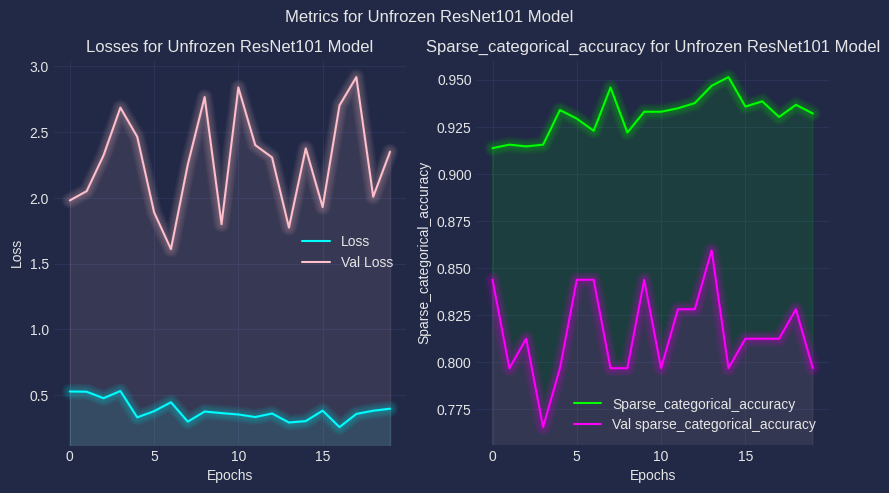

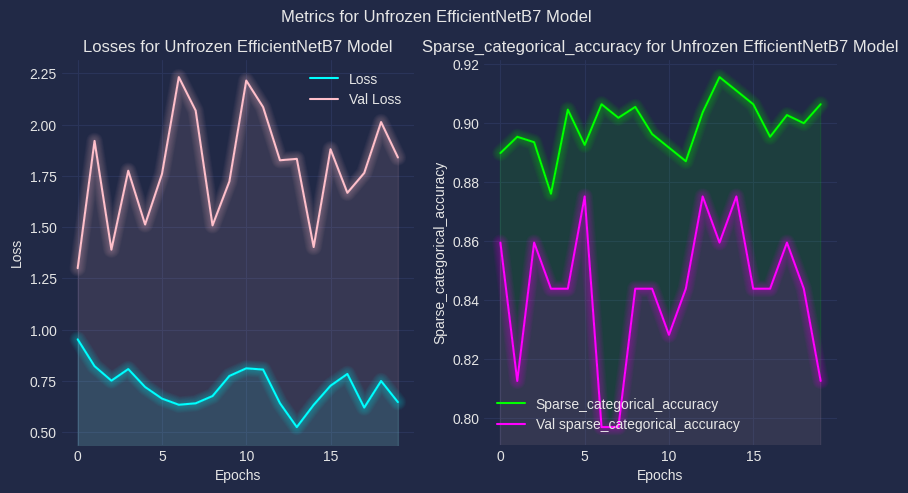

In [18]:
unfrozen_resent101_hist = unfrozen_resnet101_history.history
unfrozen_efficientnetb7_hist = unfrozen_efficientnetb7_history.history

plot_keras_metrics(
    hist=unfrozen_resent101_hist,
    model='ResNet101',
    sub='Unfrozen',
    metric='sparse_categorical_accuracy',
    colors=['cyan', 'pink', 'lime', 'magenta']
)

plot_keras_metrics(
    hist=unfrozen_efficientnetb7_hist,
    model='EfficientNetB7',
    sub='Unfrozen',
    metric='sparse_categorical_accuracy',
    colors=['cyan', 'pink', 'lime', 'magenta']
)

In [19]:
resnet101_eval = unfrozen_resnet101.evaluate(test_ds)
efficientnetb7_eval = unfrozen_efficientnetb7.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.9010
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step - loss: 0.4911 - sparse_categorical_accuracy: 0.9219


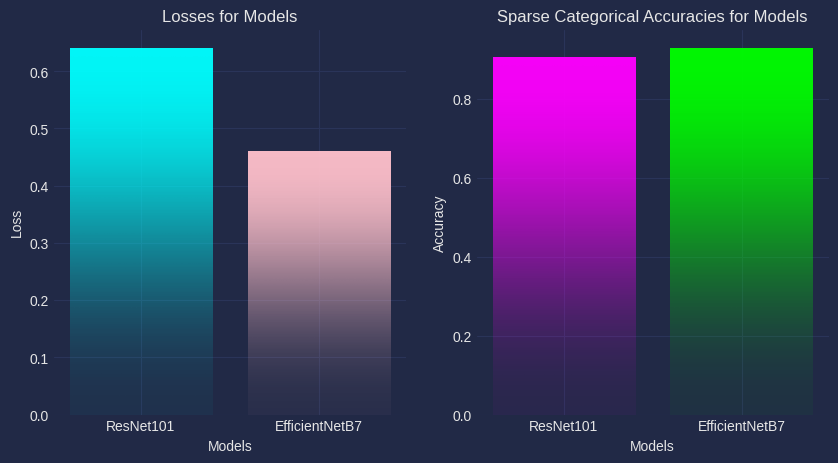

In [20]:
losses = {
    'ResNet101' : resnet101_eval[0],
    'EfficientNetB7' : efficientnetb7_eval[0]
} 
accuracies = {
    'ResNet101' : resnet101_eval[1],
    'EfficientNetB7' : efficientnetb7_eval[1]
}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set_title('Losses for Models')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Loss')
ax_0_bars = ax[0].bar(losses.keys(), losses.values(), label=list(losses.keys()), color=['cyan', 'pink'])

ax[1].set_title('Sparse Categorical Accuracies for Models')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Accuracy')
ax_1_bars = ax[1].bar(accuracies.keys(), accuracies.values(), label=list(accuracies.keys()), color=['magenta', 'lime'])

mplcyberpunk.add_bar_gradient(bars=ax_0_bars, ax=ax[0])
mplcyberpunk.add_bar_gradient(bars=ax_1_bars, ax=ax[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step


E0000 00:00:1754713965.348464      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754713965.534842      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 330ms/step


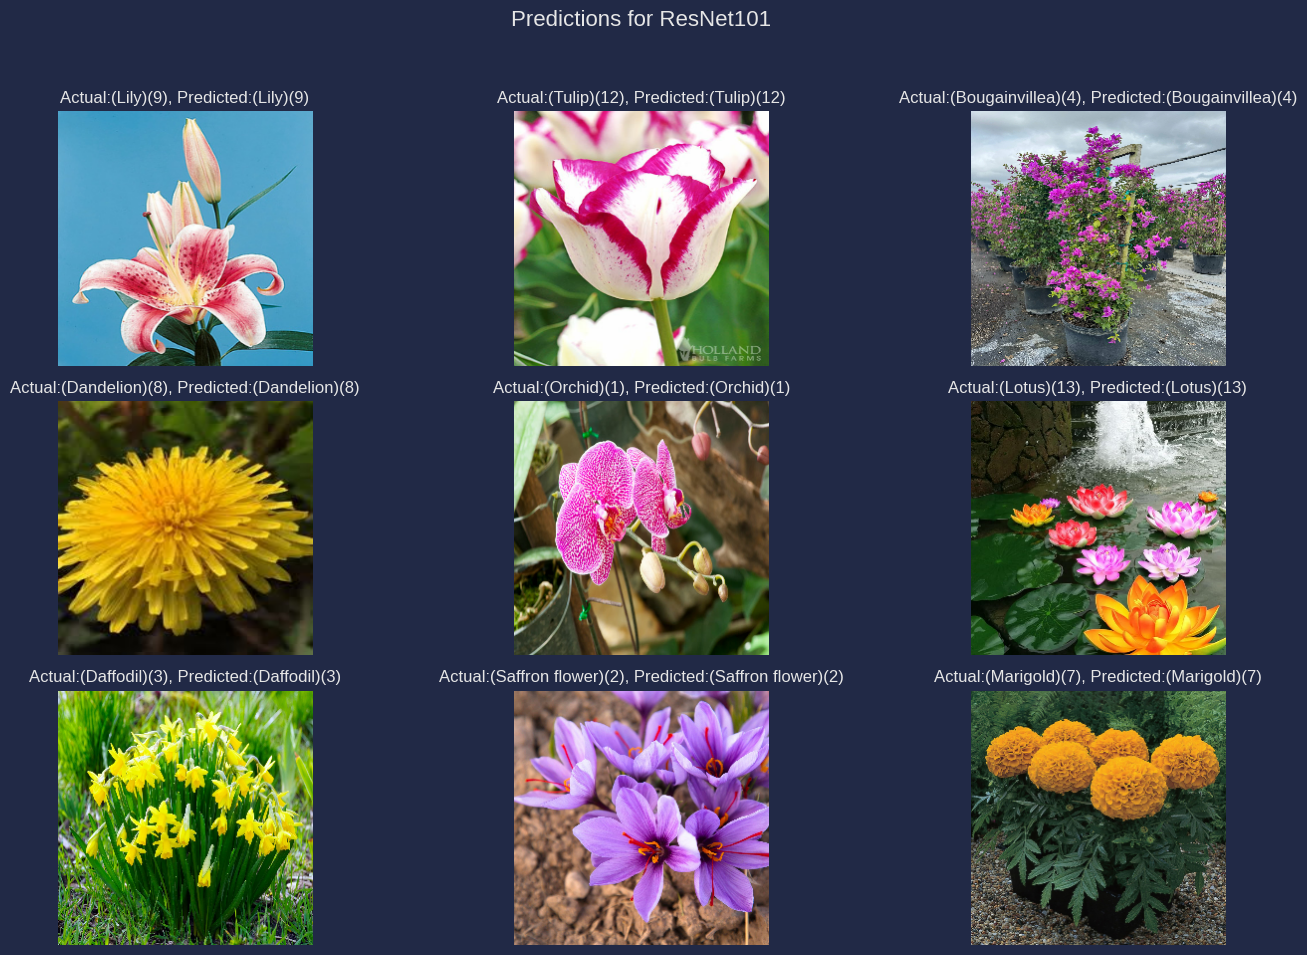

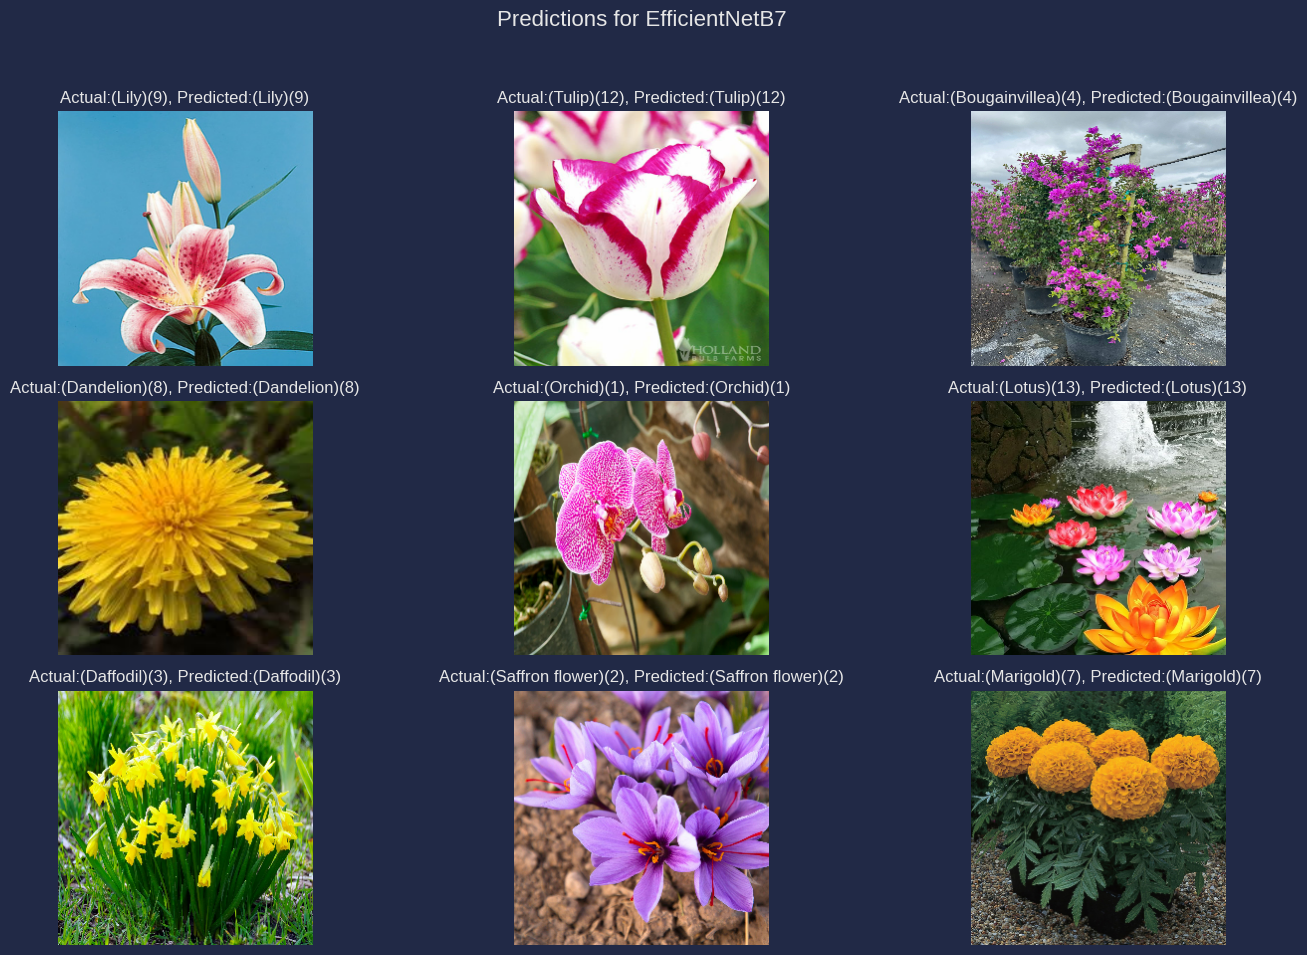

In [21]:
test_images, test_labels = next(iter(test_ds.take(1)))

resnet101_preds = unfrozen_resnet101.predict(test_images)
efficientnetb7_preds = unfrozen_efficientnetb7.predict(test_images)

def plot_predictions_revised(model_name, preds, images, labels):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    fig.suptitle(f'Predictions for {model_name}', fontsize=16)
    ax = ax.flatten()
    
    for i in range(9):
        current_pred = int(tf.argmax(np.array(preds)[i]))
        axes = ax[i]
        axes.set_title(f'Actual:({inv_class_labels[np.array(labels)[i]].capitalize()})({int(np.array(labels)[i])}), Predicted:({inv_class_labels[current_pred].capitalize()})({current_pred})')
        axes.imshow(np.array(images[i]).astype("uint8"))
        axes.axis("off")
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_predictions_revised('ResNet101', resnet101_preds, test_images, test_labels)
plot_predictions_revised('EfficientNetB7', efficientnetb7_preds, test_images, test_labels)